## Imports

In [23]:
%load_ext autoreload
%autoreload 2

%env TFDS_DATA_DIR=/datasets/tensorflow_datasets
!set_cuda_version 11.2 8.1.0

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import *

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import DataHandler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TFDS_DATA_DIR=/datasets/tensorflow_datasets
Using CUDA 11.2 at /usr/local/cuda-11.2.
Using CUDNN 8.1.0 at /usr/local/cudnn/11.2-v8.1.0


> **Note**: In `oodeel.methods.odin`, the import `from keras.utils.generic_utils import get_custom_objects` should be replaced with `from keras.utils import get_custom_objects`


## MNIST (0-4) vs MNIST (5-9)

### Data and model loading
ID data: MNIST (0-4), OOD data: MNIST (5-9)

In [24]:
data_handler = DataHandler()
normalize = lambda x: x / 255
mnist_ds = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)

# train / test set
x_train, _ = data_handler.filter_tfds(mnist_ds['train'], inc_labels=list(range(5)))
x_test, x_ood = data_handler.filter_tfds(mnist_ds['test'], inc_labels=list(range(5)))

# id / ood set
x_id = x_test

In [25]:
load = True
checkpoint_path = '../saved_models/mnist_5'

if load:
    model = tf.keras.models.load_model(checkpoint_path)
else:
    # define model
    num_classes = 5
    input_shape = (28, 28, 1)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.summary()

    # train model
    batch_size = 128
    epochs = 15

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train.batch(batch_size), validation_data=x_test.batch(batch_size), epochs=epochs)
    model.save(checkpoint_path)

### DKNN score

auroc            0.974103
fpr95tpr         0.118000
roc_auc_score    0.974092
Name: mnist-0-4-vs-5-10, dtype: float64


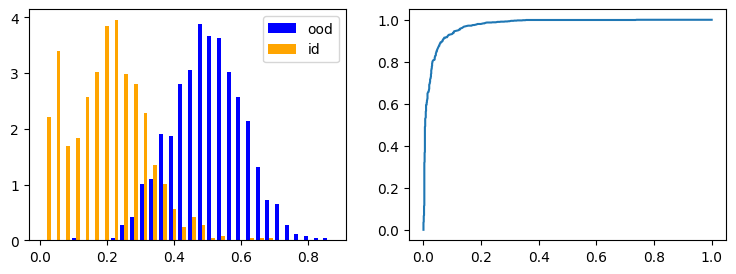

In [26]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, x_train.take(10000))
scores_id, scores_ood = oodmodel.score([x_id.take(1000), x_ood.take(1000)])

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr", roc_auc_score],
)
metrics_first_vs_last = pd.Series(metrics, name='mnist-0-4-vs-5-10')
print(metrics_first_vs_last)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

## MNIST vs Fashion MNIST


### Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [27]:
data_handler = DataHandler()
normalize = lambda x: x / 255
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)

# train / test set
x_train, x_test = ds1['train'], ds1['test']
# id / ood set
x_id, x_ood = ds1["test"], ds2["test"]
x_test_ood = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000), shuffle='True')

2023-02-03 21:33:08.993784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
load = True
checkpoint_path = '../saved_models/mnist_10'

if load:
    model = tf.keras.models.load_model(checkpoint_path)
else:
    # define model
    num_classes = 10
    input_shape = (28, 28, 1)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.summary()

    # train model
    batch_size = 128
    epochs = 15

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train.batch(batch_size), validation_data=x_test.batch(batch_size), epochs=epochs)
    model.save(checkpoint_path)

### DKNN score

2023-02-03 21:33:09.699849: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-03 21:33:09.950539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-03 21:33:10.310392: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

auroc            0.996903
fpr95tpr         0.010000
roc_auc_score    0.996913
Name: mnist-10-vs-fashion, dtype: float64


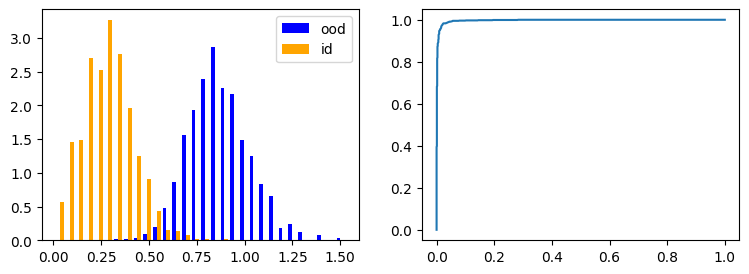

In [29]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, x_train.take(10000))
scores_id, scores_ood = oodmodel.score([x_id.take(1000), x_ood.take(1000)])

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr", roc_auc_score]
)
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

## CIFAR-10 vs SVHN

### Data and model loading
ID data: CIFAR-10, OOD data: SVHN

In [30]:
data_handler = DataHandler()
normalize = lambda x: x / 255
ds1 = data_handler.load_tfds('cifar10', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('svhn_cropped', preprocess=True, preprocessing_fun=normalize)

# train / test set
x_train, x_test = ds1['train'], ds1['test']
# id / ood set
x_id, x_ood = ds1["test"], ds2["test"]
x_test_ood = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000), shuffle='True')

# load model
# (to train the model, run: python -m notebooks.train_cifar10)
model = tf.keras.models.load_model("../saved_models/cifar10/")

2023-02-03 21:33:11.422200: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### DKNN score

2023-02-03 21:33:14.510442: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-03 21:33:14.674526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc            0.896639
fpr95tpr         0.351000
roc_auc_score    0.896644
Name: cifar-vs-svhn, dtype: float64


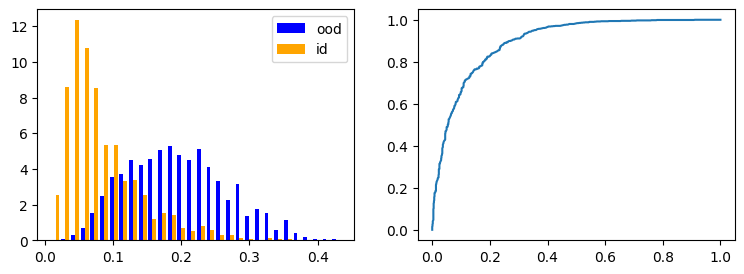

In [31]:
oodmodel = DKNN(nearest=50, output_layers_id=['pool1'])
oodmodel.fit(model, x_train.take(10000))
scores_id, scores_ood = oodmodel.score([x_id.take(1000), x_ood.take(1000)])

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr", roc_auc_score]
)
metrics_cifar = pd.Series(metrics, name='cifar-vs-svhn')
print(metrics_cifar)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

## Results

In [32]:
pd.concat([metrics_first_vs_last, metrics_fashion, metrics_cifar], axis=1).T

,auroc,fpr95tpr,roc_auc_score
mnist-0-4-vs-5-10,0.974103,0.118,0.974092
mnist-10-vs-fashion,0.996903,0.010,0.996913
cifar-vs-svhn,0.896639,0.351,0.896644
